In [1]:
import pandas as pd
import networkx as nx
from joblib import Parallel, delayed
from itertools import combinations

### 0. Подготовка данных

In [2]:
df = pd.read_csv('cdr.tsv', sep='\t' )

In [3]:
def hamming_distance(s1, s2, treshhold=0.8):
#     assert len(s1) == len(s2)
#     assert isinstance(s1, str) and isinstance(s2, str)
    treshhold = int(len(s1) * (1 - treshhold)) + 1
    
    missmatch = 0
    for char_1, char_2 in zip(s1, s2):
        if char_1 != char_2:
            missmatch += 1
            if missmatch == treshhold:
                return False
    
    return True

def task(seqs):
    results = []
    for seq_1, seq_2 in combinations(seqs, 2):
        if hamming_distance(seq_1, seq_2):
            results.append((True, seq_1, seq_2))
        else:
            results.append((False, seq_1, None))
            results.append((False, seq_2, None))
    return results

In [4]:
df['lenght_seq'] = df['cdr3'].apply(len)
df = df[['lenght_seq', 'cdr3']]

### 1. Создание HD графа

In [5]:
%%time
G = nx.Graph()

grouped_seqs = []
for index, row in df.groupby('lenght_seq', as_index=False).aggregate(lambda x: x.tolist()).iterrows():
    if len(row[1]) > 1:
        seqs = row[1]
        grouped_seqs.append(seqs)
    else:
        G.add_node(row[1][0])

grouped_res = Parallel(n_jobs=-1)(delayed(task)(group) for group in grouped_seqs)
for group in grouped_res:
    for result_connected, seq_1, seq_2 in group:
        if result_connected:
            G.add_edge(seq_1, seq_2)
        else:
            G.add_node(seq_1)
            G.add_node(seq_2)

Wall time: 19.6 s


### 2. Информация для 2 таблицы

In [26]:
print('Количество компонент:', nx.number_connected_components(G))
print('Количество сиквенсов в самой большой компоненте:', len(sorted(nx.connected_components(G), key=len, reverse=True)[0]))
print('Количество компонент с менее чем 10 сиквенсами:' , sum(1 for component in nx.connected_components(G) 
                                                              if len(component) < 10))

Количество компонент: 548
Количество сиквенсов в самой большой компоненте: 122
Количество компонент с менее чем 10 сиквенсами: 502


### 3. Информация для распределения V генов

In [74]:
df = pd.read_csv('cdr.tsv', sep='\t' )
df['v_call_new'] = df.v_call.apply(lambda x: x.split('*')[0])

In [76]:
from collections import Counter

counter_v_call = Counter()
for component in nx.connected_components(G):
    counter_v_call += Counter(set(df[df['cdr3'].isin(component)].v_call_new))

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

In [86]:
x, y = [], []
for x_, y_ in sorted(counter_v_call.items(), key=lambda x: x[1], reverse=True):
    x.append(x_)
    y.append(y_)

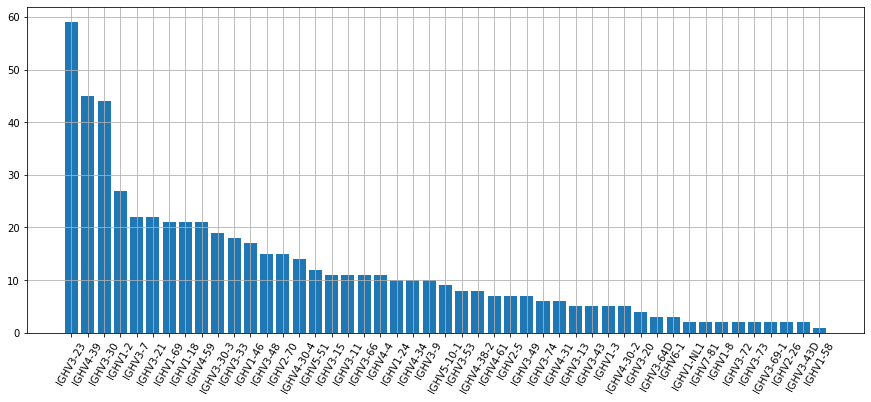

In [96]:
plt.figure(figsize=(15, 6))
plt.xticks(rotation=60)
plt.bar(x, y)
plt.grid()

### 4. Предобработка для лого

In [6]:
largest_component = sorted(nx.connected_components(G), key=len, reverse=True)[0]

In [10]:
with open('logo.fasta', 'w') as f:
    for index, seq in enumerate(largest_component):
        f.write(f'>seq_id_{index}\n' + seq + '\n')

### 5. Предобработка для филогении

In [28]:
df = pd.read_csv('cdr.tsv', sep='\t' )

for value in df[df['cdr3'].isin(largest_component)]['sequence'].unique():
    print(value)

GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTCCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCGGTCTCTGGATTCACCGCCACCAGCAACTACTTGAGCTGGGTCCGCCAGGCTCCAGGGACGGGGCTGGAGTGGGTCTCAACTATTTATACCGATGGTGGCACGCTCTACGCAGACTCCGTGCGGGACAGGTTCACCATCTCCAGAGACACTTCCAATAACACACTGAATCTCCAAATCAACGGCCTGAGAGCCGAGGACACGGCTGTGTACTTCTGTGCGACAGAAACCTTCATCGATGTAGATCTGAAAGTATGGGGTGTCTTTGACTTCTGGGGCCAAGGGACAATGGTCACCGTCTCTTCAG
GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTCCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCGGTCTCTGGATTCACCGTCAACAGCAACTACTTGAGCTGGGTCCGCCAGGCTCCAGGGACGGGGCTGGAGTGGGTCTCAACTATTTATACCAATGGTGGCACGCTCTACGCAGACTCCGTGCGGGACAGGTTCACCATCTCCAGAGACACTTCCAATAACACACTGAATCTCCAAATCAACGGCCTGAGAGCCGAGGACACGGCTGTGTACTTCTGTGCGACAGAAACCTTCATCGATGTAGATCTGAAAGTATGGGGTGTCTTTGACTTCTGGGGCCAAGGGACAATGGTCACCGTCTCTTCAG
GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTCCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCGGTCTCTGGATTCACCGTCAACAGCAACTACTTGAGCTGGGTCCGCCAGGCTCCAGGGACGGGGCTGGAGTGGGTCTCAACTATTTATACCGATGGTGGCACGCTCTACGCAGATTCCGTGCGGGACAGGTTCACCATCTCCAGAGACACTTCCAATAACACACTGAATCTCCAAATCAACGGC

In [43]:
with open('phylo.fasta', 'w') as f:
    for index, value in df[df['cdr3'].isin(largest_component)][['sequence']].iterrows():
        f.write(f'>{index}\n' + value['sequence'] + '\n')